In [1]:
import csv
import matplotlib.pyplot as plt
from snsphd import viz
import numpy as np
from snsphd.hist import SplineTool

from scipy.signal import find_peaks
from collections import namedtuple
from typing import Tuple

Colors, swatches = viz.phd_style(jupyterStyle=True, svg_mode=True)
from dataclasses import dataclass

from scipy.optimize import leastsq, curve_fit

import json

# %load_ext snakeviz

In [2]:
def load_file(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)

    start_idx = None
    for i in range(len(data)):
        if len(data[i]) >=3:
            if data[i][0] == 'Stop':
                start_idx = i + 1
                break
    if start_idx is None:
        print("Could not find start of data")
    else:
        wavelengths = []
        values = []
        for i in range(start_idx, len(data)):
            wavelengths.append(float(data[i][0]))
            values.append(float(data[i][1]))
    return np.array(wavelengths), np.array(values)

name_path = "..//data//shg_8_nm_filter//full power//WaveData20220726_012.csv"
wavelengths, values = load_file(name_path)
    

0.4796403994279217


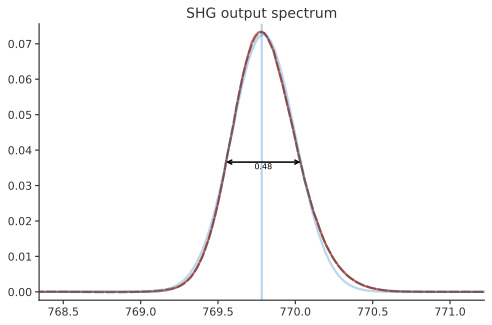

In [3]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2)



fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.plot(wavelengths, values, color=Colors['red'])


spline = SplineTool(np.array(values), np.array(wavelengths))
ax.plot(*spline.plot_spline(wavelengths,.001), color='k', ls='--', alpha=0.3)
spline.plot_width_at_level_arrows(ax, 0.5)
root = spline.full_width_at_level(0.5, .0001)

ax.set_xlim(spline.spline_max().x - 3*root.width, spline.spline_max().x + 3*root.width)
print(root.right-root.left)
ax.set_title("SHG output spectrum")
ax.axvline(spline.spline_max().x, alpha=0.3)
ax.plot(*spline.plot_gaussian_fit(), alpha=0.3, label="gaussian fit")


In [4]:
print("SHG wavelength: ", spline.spline_max().x)
print("SHG bandwidth sigma: ", spline.sigma())


SHG wavelength:  769.7826952387038
SHG bandwidth sigma:  0.2036689594173765


In [5]:
def scale_units(number):
    if number >= 1e3 and number < 1e6:
        return number/1e3, "K"
    if number >= 1e6 and number < 1e9:
        return number/1e6, "M"
    if number >= 1e9 and number < 1e12:
        return number/1e9, "G"
    if number >= 1e12 and number < 1e15:
        return number/1e12, "T"
    if number >= 1e15 and number < 1e18:
        return number/1e15, "Y"


def frequency_and_bandwidth(wl, wl_sigma):
    c = 299792458

    wl*=1e-9
    wl_sigma*=1e-9

    v_start = c/(wl + (wl_sigma/2))
    v_end = c/(wl - (wl_sigma/2))
    sigma_v = v_end - v_start
    freq, freq_unit = scale_units(c/wl)
    sigma_v, sigma_v_unit = scale_units(sigma_v)


    bw = namedtuple("FreqBandwidth", ["freq", "freq_unit", "sigma", "sigma_unit"])
    return bw(freq=freq, freq_unit=freq_unit+"Hz", sigma=sigma_v, sigma_unit = sigma_v_unit+"Hz")


In [6]:
spline.spline_max().x

769.7826952387038

In [7]:
frequency_and_bandwidth(spline.spline_max().x, spline.sigma())

FreqBandwidth(freq=389.450762993622, freq_unit='THz', sigma=103.0408107664375, sigma_unit='GHz')

In [8]:
frequency_and_bandwidth(1530, 0.4)

FreqBandwidth(freq=195.94278300653593, freq_unit='THz', sigma=51.22687224959375, sigma_unit='GHz')

In [9]:
193e12/1e15

0.193

In [10]:
with open("simplified_jsi_data_x8.json") as file:
    data = json.load(file)

In [11]:
pump_sigma_omega = 2*np.pi*frequency_and_bandwidth(spline.spline_max().x, spline.sigma()).sigma*1e9

In [12]:
for i in range(len(data["coinc_set"])):
    for j in range(len(data["coinc_set"][0])):
        data["coinc_set"][i][j] = round(data["coinc_set"][i][j], 1)

data["wl_B"].reverse()

if len(data["coinc_set"]) == 16:
    st = "\t        "
else:
    st = "\t "
for item in data["wl_B"]:
    if len(data["coinc_set"]) == 16:
        st = st + " " + str(item[:-3])
    if len(data["coinc_set"]) == 8:
        st = st + " " + str(item)
print(st)
np.array(data["coinc_set"])
for i, row in enumerate(data["coinc_set"]):
    st = str(data["wl_A"][i])
    for item in row:
        st = st + "\t   " + str(item)
    print(st)

# wl_B is along the top, 52 to 59
# wl_A is along the side, 35 to 42


	  1530.33 1531.12 1531.9 1532.68 1533.47 1534.25 1535.04 1535.82
1549.32	   68.5	   32.9	   4.3	   0.0	   0.0	   0.0	   0.0	   0.0
1548.51	   25.7	   65.6	   38.0	   5.4	   0.0	   0.0	   0.0	   0.0
1547.72	   2.7	   25.4	   62.9	   32.3	   4.7	   0.0	   0.0	   0.0
1546.92	   0.0	   2.6	   27.6	   69.5	   40.2	   6.9	   0.0	   0.0
1546.12	   0.0	   0.0	   2.5	   25.6	   63.7	   36.3	   4.0	   0.0
1545.32	   0.0	   0.0	   0.0	   2.8	   29.0	   82.4	   37.6	   5.2
1544.53	   0.0	   0.0	   0.0	   0.0	   2.2	   23.9	   61.0	   30.5
1543.73	   0.0	   0.0	   0.0	   0.0	   0.0	   2.7	   27.1	   72.9


In [13]:
flat_coinc = []
flat_wl_A = []
flat_wl_B = []
# flat_ch_A = []
# flat_ch_B = []

for i, row in enumerate(data["coinc_set"]):
    for j, column in enumerate(row):
        flat_coinc.append(column)
        flat_wl_B.append(data["wl_B"][j])
        flat_wl_A.append(data["wl_A"][i])

flat_coinc = np.array(flat_coinc)
flat_wl_A = np.array(flat_wl_A)
flat_wl_B = np.array(flat_wl_B)

zeros_mask = (flat_coinc!=0)
# print(zeros_mask)
flat_coinc = flat_coinc[zeros_mask]
flat_wl_A = flat_wl_A[zeros_mask]
flat_wl_B = flat_wl_B[zeros_mask]

# print("number of items: ", len(flat_coinc))
# for i in range(len(flat_coinc)):
#     print(flat_coinc[i], flat_wl_A[i], flat_wl_B[i])



In [14]:
idler = flat_wl_A # long to short
signal = flat_wl_B # short to long

In [15]:
data3d = np.array(list(zip(idler,signal,flat_coinc)))

In [83]:

@dataclass
class ExtraordinaryIndex:
    a1: float = 5.756
    a2: float = 0.0983
    a3: float = 0.2020
    a4: float = 189.32
    a5: float = 12.52
    a6: float = 1.32e-2
    b1: float = 2.86e-6
    b2: float = 4.7e-8
    b3: float = 6.113e-8
    b4: float = 1.516e-4

@dataclass
class OrdinaryIndex:
    a1: float = 5.653
    a2: float = 0.1185
    a3: float = 0.2091
    a4: float = 89.61
    a5: float = 10.85
    a6: float = 1.97e-2
    b1: float = 7.941e-7
    b2: float = 3.134e-8
    b3: float = -4.641e-9
    b4: float = -2.188e-6

def Mgo_doped_Linb03_calculate_indexes(lambda_: float, temp: float, ei: ExtraordinaryIndex, eo: OrdinaryIndex) -> Tuple[float, float, float]:
    # lambda_ *= 1e-3 # Convert for Sellmeir Coefficients

    lamb = lambda_*1e-3
    F = (temp - 24.5)*(temp+570.82)

    l2 = lamb**2
    nz = (ei.a1 + ei.b1*F + (ei.a2 + ei.b2*F)/(l2 - (ei.a3+ei.b3*F)**2) + (ei.a4+ei.b4*F)/(l2 - ei.a5**2) - ei.a6*l2)**0.5

    nx = (eo.a1 + eo.b1*F + (eo.a2 + eo.b2*F)/(l2 - (eo.a3+eo.b3*F)**2) + (eo.a4+eo.b4*F)/(l2 - eo.a5**2) - eo.a6*l2)**0.5
    ny = nx

    return nx


def Linb03_calculate_indexes(lambda_: float, temp: float):
    lamb = lambda_*1e-3
    # lambda_ = lambda_*1e-3
    l2 = lamb**2

    nx = (4.9048 - 0.11768/(0.04750 - l2) - 0.027169*l2 )**0.5
    ny = nx
    nz = (4.5820 - 0.099169/(0.044432 - l2) -  0.021950*l2)**0.5

    dnx = -0.874e-6
    dny = dnx
    dnz = 39.073e-6



    nx = nx + (temp -20.0)*dnx
    ny = ny + (temp -20.0)*dny
    nz = nz + (temp -20.0)*dnz

    return nx


print(Linb03_calculate_indexes(1540, 50)) #, ExtraordinaryIndex(), OrdinaryIndex()))
print(Mgo_doped_Linb03_calculate_indexes(1540, 50, ExtraordinaryIndex(), OrdinaryIndex()))


2.2115344628379754
2.2121078856463043


In [84]:
pump_sigma_omega

647424508247.5522

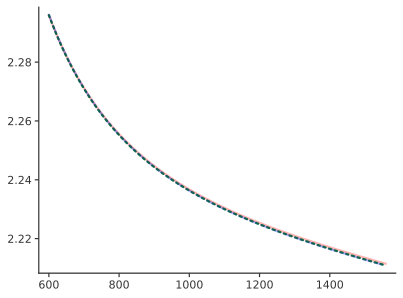

In [101]:

from dataclasses import dataclass

@dataclass
class DetectorParams:
    sigma: float = 53.0
    w_0: float = 1550.0

@dataclass
class SpdcParams:
    w_central: float = 1539.77
    L: float = 1e5 #        solve for L
    sigma_p: float = pump_sigma_omega   # 2*np.pi/(100*10**(-12))
    gamma: float = 1/(18300) # 1/(18.3 um)


@dataclass
class JointSpectrumParams:
    detector: DetectorParams
    spdc: SpdcParams
c = 299792458 * 1e9 # speed of light in nm/s

temp = 50


def refractive_index_ppln(wavelength):
    '''
    This is the large n(\lambda) equation in Sam's paper
    '''
    w_in_um = 1e-3*wavelength #convert nm to um
    w2 = np.square(w_in_um)
    out =  1+(2.6734*w2)/(w2 - 0.01764)
    out += (1.2290*w2)/(w2 - 0.05914)
    out += (12.614*w2)/(w2 - 474.6)
    return np.sqrt(out)


def gaussian2D(x, y, x_0, y_0, sigma_x, sigma_y):
    aux =  ((x-x_0)/sigma_x)**2
    aux += ((y-y_0)/sigma_y)**2
    norm = 2 * np.pi * sigma_x * sigma_y
    return np.exp(-aux)/norm


def detector_profile(w_idler, w_signal, params: DetectorParams):
    '''
    I need to decide if our why I'm using this. 
    Would I also need the loss of all the DWDM channels?
    Well Sam couldn't characterize her narroband filter versus wavelength relationship...

    w0 here is the center of the guassian
    this creates a 2d guassian centered at (w_0, w_0) with different standard deviations
    '''
    return gaussian2D(w_idler, w_signal, params.w_0, params.w_0, params.sigma, params.sigma)


def pump_envelope(omega_i, omega_s, omega_0, sigma_p):
    '''
    omega_i: frequency of idler
    omega_s: frequency of signal
    omega_0: just an offset factor I guess. See what she sets it to
    sigma_p: standard deviation of the pump. (I have this for the SHG)
    '''
    #return gaussian2D(omega_i,omega_s,omega_0, omega_0, sigma_p, sigma_p)
    nu_i = omega_i - omega_0
    nu_s = omega_s - omega_0
    # return np.exp(-(nu_i+nu_s)**2/(sigma_p**2)) #Original line

    # No normalization in this gaussian? Yes we could
    aux = (nu_i+nu_s)/sigma_p
    return np.exp(-0.5*np.square(aux))

def phase_mismatch(w_idler, w_signal, w_0, gamma): #nanometers
    w_pump = w_0
    # n_i = refractive_index_ppln(w_idler)
    # n_s = refractive_index_ppln(w_signal)
    # n_p = refractive_index_ppln(w_pump) #should be index of refraction @ 770 nm right?

    n_i = Linb03_calculate_indexes(w_idler, temp)
    n_s = Linb03_calculate_indexes(w_signal, temp)
    n_p = Linb03_calculate_indexes(w_pump, temp)
    # print("w_idler: ", w_idler)


    k_i, k_s, k_p = 2*np.pi/w_idler, 2*np.pi/w_signal, 2*np.pi/w_pump

    # gamma should be units of 1/nm
    # polling period is 18.3 um

    # 1/(polling_period) is 1/18.3 1/um
    return 2*np.pi*((n_p/w_pump) - (n_i/w_idler) - (n_s/w_signal) - gamma)

    # # return_value = n_p*k_p - n_s*k_s - n_i*k_i
    # return n_p*k_p - n_s*k_s - n_i*k_i #1/nm

def sinc2(omega_i, omega_s, omega_0, gamma, L):
    print("omega_i: ", omega_i)
    # No 2pi*c to go from omega to wavelength?
    c = 3*10**8 * 10**9 #nm/s
    # delta_k = phase_mismatch(2*np.pi*c/omega_i,2*np.pi*c/omega_s,2*np.pi*c/omega_0)-gamma
    delta_k = phase_mismatch(2*np.pi*c/omega_i,2*np.pi*c/omega_s,2*np.pi*c/omega_0, gamma)

    aux = L*delta_k/2 # line 454 in pm-lib-momentum.js
    return (np.sin(aux)/aux)**2#np.square(np.sinc(aux))

def sinc2_monochromatic(omega_i, omega_s, omega_0, gamma, L):
    c = 3.*10**8 * 10**9 #nm/s
    twoPiC = 2.*np.pi*c
    # delta_k = phase_mismatch(twoPiC/omega_i, twoPiC/omega_s, twoPiC/omega_0) - gamma
    delta_k = phase_mismatch(twoPiC/omega_i, twoPiC/omega_s, twoPiC/omega_0, gamma)
    print("L is ", L, " with unites of nm")
    print("delta K is ", delta_k, " with units of 1/nm I think")
    return np.square(np.sinc(0.5*L*delta_k/np.pi))


def spdc_profile(w_idler, w_signal, gamma, params: SpdcParams): # w_central, L, sigma_p=2*np.pi/(40e-12), gamma= 3.9e-4):
    # sigma_p = 2*np.pi/100*10**(-12)
    c = 3*10**8 * 10**9 #nm/s
    omega_i, omega_s, omega_0 = 2*np.pi*c/w_idler, 2*np.pi*c/w_signal, 2*np.pi*c/params.w_central
    # return sinc2(omega_i, omega_s, omega_0, gamma, params.L)*pump_envelope(omega_i, omega_s, omega_0,params.sigma_p)
    return sinc2_monochromatic(omega_i, omega_s, omega_0, gamma, params.L)*pump_envelope(omega_i, omega_s, omega_0,params.sigma_p)


def joint_spectrum(w_idler, w_signal, gamma, A, params: JointSpectrumParams): # gamma, A, sigma_p=2*np.pi/(100*10**(-12)), sigma_d=53., w_central=1540., L= 1e7):
    out =  A*detector_profile(w_idler, w_signal, params.detector)
    out *= spdc_profile(w_idler, w_signal, gamma, params.spdc)
    return out

# def _joint_spectrum(M, gamma, A):
#     x, y = M[:,0], M[:,1]
#     params = JointSpectrumParams(detector=DetectorParams, spdc=SpdcParams)
#     return joint_spectrum(x,y, gamma, A, params)


def wrapper_joint_spectrum(params):
    def _joint_spectrum(M, gamma, A, params=params):
        x, y = M[:,0], M[:,1]
        return joint_spectrum(x,y, gamma, A, params)
    return _joint_spectrum


a = np.arange(600.0, 1560.0, 1.0).astype('float')
plt.figure()
plt.plot(a, Mgo_doped_Linb03_calculate_indexes(a, 50, ExtraordinaryIndex(), OrdinaryIndex()), color='red', alpha=0.3)
plt.plot(a, Linb03_calculate_indexes(a, 50), color='green', alpha=0.9, ls=':')
# plt.ylim(0,3)
plt.plot(a, refractive_index_ppln(a), color='blue', alpha=0.3, ls='--')

In [96]:
c = 3*10**8 * 10**9
print(c)

(2*np.pi*c/1540)/1e15

# print(3*10**8)

300000000000000000


1.223997137762257

In [97]:
print("")
print("refractive index @ 1540 nm: ",refractive_index_ppln(1540))
print("refractive index @ 770 nm: ",refractive_index_ppln(770))
print("")

print("choose that idler goes from short wavelength (like 1517) to up to 1540")
print("choose that signal goes from 1540 to longer wavelegnth")


refractive index @ 1540 nm:  2.21145099670458
refractive index @ 770 nm:  2.259374268658871

choose that idler goes from short wavelength (like 1517) to up to 1540
choose that signal goes from 1540 to longer wavelegnth


In [98]:
gamma_guess = 3e-4 # 3.9e-4
A_guess = 3e7 # 7481585.54714451
p_guess=[gamma_guess, A_guess]#,sigma_p_guess]
#if we want to float L, should fix sigma_p, because both have effects on width (can't optimize)
#vice versa, if we want to float sigma_p, should fix L
# you can use optimize.curve_fit to fit 2D data. See here: https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/
params = JointSpectrumParams(detector=DetectorParams(), spdc=SpdcParams())
popt, pcov = curve_fit(wrapper_joint_spectrum(params),data3d[:,:2], data3d[:,2], p0=p_guess)


gamma, A = popt
print("gamma: ", gamma)
print("A: ", A)

L is  100000.0  with unites of nm
delta K is  [-0.00149528 -0.00149048 -0.00148575 -0.00150008 -0.00149529 -0.00149056
 -0.00148583 -0.00150477 -0.00149998 -0.00149524 -0.00149052 -0.00148574
 -0.00150473 -0.0015     -0.00149527 -0.00149049 -0.00148577 -0.00150475
 -0.00150003 -0.00149525 -0.00149053 -0.00148576 -0.00150479 -0.00150001
 -0.00149529 -0.00149052 -0.00148581 -0.00150472 -0.0015     -0.00149523
 -0.00149052 -0.00150477 -0.0015     -0.0014953 ]  with units of 1/nm I think
L is  100000.0  with unites of nm
delta K is  [-0.00149528 -0.00149048 -0.00148575 -0.00150008 -0.00149529 -0.00149056
 -0.00148583 -0.00150477 -0.00149998 -0.00149524 -0.00149052 -0.00148574
 -0.00150473 -0.0015     -0.00149527 -0.00149049 -0.00148577 -0.00150475
 -0.00150003 -0.00149525 -0.00149053 -0.00148576 -0.00150479 -0.00150001
 -0.00149529 -0.00149052 -0.00148581 -0.00150472 -0.0015     -0.00149523
 -0.00149052 -0.00150477 -0.0015     -0.0014953 ]  with units of 1/nm I think
L is  100000.0  with u

In [99]:
@dataclass
class GaussianFilterParams:
    center_x: float
    center_y: float
    sigma_x: float
    sigma_y: float
    
def cwdm_profile(x, y, sigma_x=13., sigma_y=13.):
    # There is no factor 2 to normalize this one? We could
    return gaussian2D(x, y, 1530, 1550, sigma_x, sigma_y) + gaussian2D(x, y, 1550, 1530, sigma_x, sigma_y)


def single_filter(x, y, params: GaussianFilterParams):
    return gaussian2D(x, y, params.center_x, params.center_y, params.sigma_x, params.sigma_y)



In [106]:
# gamma, A = popt



# gamma = 0.0000546
gamma = 0.0000546
temp=50
A = 1000
params.spdc.L = 1e7

# params.spdc.L = params.spdc.L/54
# params.spdc.L = 


num_points = 1000

# fine_idler_wl = np.linspace(1480, 1610, num_points)
# fine_signal_wl = np.linspace(signal[0] - 0.4, signal[-1] + 0.4, num_points)

id_wavelengths = np.linspace(1480, 1610, num_points)
sig_wavelengths = np.linspace(1480, 1610, num_points)

# id_wavelengths = np.linspace(1538, 1520, num_points)
# sig_wavelengths = np.linspace(1540, 1560, num_points)


X, Y = np.meshgrid(id_wavelengths, sig_wavelengths)
detector_mat = detector_profile(X, Y, params.detector)
# pump_mat = pump_envelope(
#     2 * np.pi * c / X, 2 * np.pi * c / Y, 2 * np.pi * c / 1540, params.spdc.sigma_p
# )
sinc2_mat = sinc2_monochromatic(2 * np.pi * c / X, 2 * np.pi * c / Y, 2 * np.pi * c / 1540, gamma, params.spdc.L)
JSI_mat = joint_spectrum(X, Y, gamma, A, params)
cwdm_mat = cwdm_profile(X, Y)

JSI_mat_cwdm = JSI_mat * cwdm_mat
JSI_mat_cwdm = JSI_mat_cwdm * np.max(JSI_mat) / np.max(JSI_mat_cwdm)



################################ Plot

fontsize = 10*1.5
fontsize_x = 9*1.5
fontsize_y = 9*1.5
labelsize = 8*1.5
# levels = np.arange(0, 1.005, 0.005)
ticks = np.arange(0, 1.25, 0.25)
# Plotting modes



fig, ax = plt.subplots(1,1,figsize=(8,7))
ax_text_loc = (-0.01, 1.11)
# cp = ax.contourf(
#     id_wavelengths, sig_wavelengths, sinc2_mat / np.max(sinc2_mat), 80, levels=levels
# )
extent = [sig_wavelengths.min(), sig_wavelengths.max(), id_wavelengths.min(), id_wavelengths.max()]
cp = ax.imshow(sinc2_mat / np.max(sinc2_mat), extent=extent, aspect='equal', origin='lower')

ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
ax.set_title("Phase matching amplitude", fontsize=fontsize)
cbar = fig.colorbar(cp, ax=ax)
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_ticks(ticks)
ax.annotate(
    "a)",
    xy=ax_text_loc,
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    fontsize=fontsize,
)






L is  10000000.0  with unites of nm
delta K is  [[-0.0097934  -0.00979256 -0.00979171 ... -0.00901928 -0.00901856
  -0.00901785]
 [-0.00979256 -0.00979171 -0.00979087 ... -0.00901843 -0.00901772
  -0.00901701]
 [-0.00979171 -0.00979087 -0.00979002 ... -0.00901759 -0.00901687
  -0.00901616]
 ...
 [-0.00901928 -0.00901843 -0.00901759 ... -0.00824515 -0.00824444
  -0.00824373]
 [-0.00901856 -0.00901772 -0.00901687 ... -0.00824444 -0.00824373
  -0.00824301]
 [-0.00901785 -0.00901701 -0.00901616 ... -0.00824373 -0.00824301
  -0.0082423 ]]  with units of 1/nm I think
L is  10000000.0  with unites of nm
delta K is  [[-0.00979894 -0.0097981  -0.00979725 ... -0.00902427 -0.00902356
  -0.00902284]
 [-0.0097981  -0.00979725 -0.0097964  ... -0.00902343 -0.00902271
  -0.009022  ]
 [-0.00979725 -0.0097964  -0.00979556 ... -0.00902258 -0.00902187
  -0.00902115]
 ...
 [-0.00902427 -0.00902343 -0.00902258 ... -0.0082496  -0.00824889
  -0.00824817]
 [-0.00902356 -0.00902271 -0.00902187 ... -0.00824889 -

Text(-0.01, 1.11, 'a)')

In [45]:
sinc2_monochromatic(2 * np.pi * c / X, 2 * np.pi * c / Y, 2 * np.pi * c / 1540, gamma, params.spdc.L)

array([[1.45339174e-03, 1.50909523e-03, 1.56091292e-03, ...,
        2.99170167e-03, 3.16636471e-03, 3.33733112e-03],
       [1.50909523e-03, 1.56092176e-03, 1.60851096e-03, ...,
        3.19824488e-03, 3.36846912e-03, 3.53401341e-03],
       [1.56091292e-03, 1.60851096e-03, 1.65154608e-03, ...,
        3.39938568e-03, 3.56400999e-03, 3.72301443e-03],
       ...,
       [2.99170167e-03, 3.19824488e-03, 3.39938568e-03, ...,
        8.59339767e-05, 9.71483957e-05, 1.08788138e-04],
       [3.16636471e-03, 3.36846912e-03, 3.56400999e-03, ...,
        9.71483957e-05, 1.08790064e-04, 1.20799496e-04],
       [3.33733112e-03, 3.53401341e-03, 3.72301443e-03, ...,
        1.08788138e-04, 1.20799496e-04, 1.33119487e-04]])

In [46]:
np.max(sinc2_mat)

0.9999999998158555

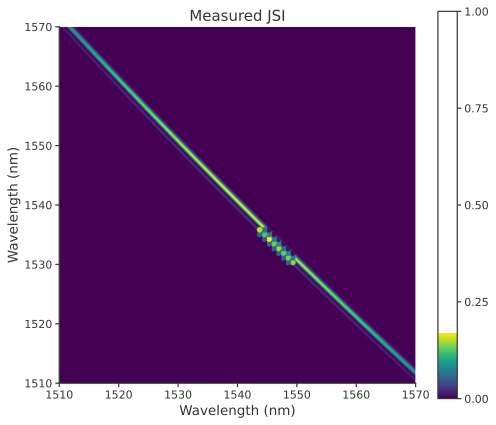

In [76]:
gamma = 0.0000546
temp=50
A = 10000


num_points_svd = 1000
id_wavelengths_svd = np.linspace(1510, 1570, num_points_svd)
sig_wavelengths_svd = np.linspace(1510, 1570, num_points_svd)

# id_wavelengths_svd = np.linspace(1540, 1570, num_points_svd)
# sig_wavelengths_svd = np.linspace(1510, 1540, num_points_svd)
X_svd, Y_svd = np.meshgrid(id_wavelengths_svd, sig_wavelengths_svd)
JSI_mat_svd = joint_spectrum(X_svd, Y_svd, gamma, A, params)
# cwdm_mat_svd = cwdm_profile(X_svd, Y_svd, ) # I could just replace this...

cwdm_mat_svd = single_filter(X_svd, Y_svd, GaussianFilterParams(center_x=1549.32, center_y= 1530.33, sigma_x=0.2, sigma_y=0.2))


JSI_mat_cwdm_svd = JSI_mat_svd * cwdm_mat_svd
JSI_mat_cwdm_svd = JSI_mat_cwdm_svd * np.max(JSI_mat_svd) / np.max(JSI_mat_cwdm_svd)


# with the CWDM filter
u_cwdm, s_cwdm, vh_cwdm = np.linalg.svd(
    JSI_mat_cwdm_svd
)  # /np.sum(signal1_idler_twofold))
svd_cwdm = s_cwdm / np.sum(s_cwdm)
# print(svd_cwdm)


# without the CWDM filter
u, s, vh = np.linalg.svd(JSI_mat)  # /np.sum(signal1_idler_twofold))
svd = s / np.sum(s)



#### PLOT JSIs#######################



levels = np.arange(0, 1.005, 0.005)
ticks = np.arange(0, 1.25, 0.25)
fig, ax = plt.subplots(1, 1, figsize=(8,7))

start_id = 0
end_id = 1000
start_sig = 0
end_sig = 1000

# cp = ax.contourf(
#     id_wavelengths[start_id:end_id], sig_wavelengths[start_sig:end_sig], JSI_mat[start_sig:end_sig,start_id:end_id] / np.max(JSI_mat[start_sig:end_sig,start_id:end_id] ), 80, levels=levels
# )

extent = [sig_wavelengths_svd[start_sig:end_sig].min(), sig_wavelengths_svd[start_sig:end_sig].max(), id_wavelengths_svd[start_id:end_id].min(), id_wavelengths_svd[start_id:end_id].max()]
cp = ax.imshow(JSI_mat_svd[start_sig:end_sig,start_id:end_id], extent=extent, aspect='equal', origin='lower')

# cp = ax.imshow(JSI_mat_cwdm_svd[start_sig:end_sig,start_id:end_id], extent=extent, aspect='equal', origin='lower')


sc = ax.scatter(
    flat_wl_A,
    flat_wl_B,
    facecolors="None",
    c=flat_coinc / np.max(flat_coinc),
    cmap="viridis",
    s=30,
    alpha=1,
)
ax.set_title("Measured JSI", fontsize=fontsize)
ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
cbar = fig.colorbar(cp, ax=ax)  # , levels = levels)
cbar.set_ticks(ticks)
# plt.clim(0,1)

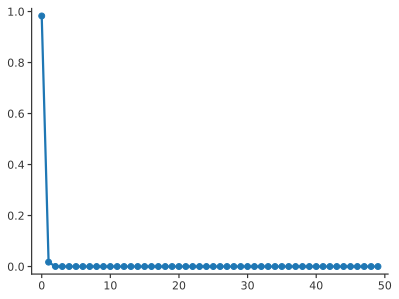

In [65]:
plt.plot(svd_cwdm[:50], '-o')

In [20]:
sum = np.sum(svd_cwdm**2)
K_cwdm = 1 / sum
print("svd cwdm")
# print(svd_cwdm)
print("K cwdm= ", K_cwdm)
print()

print("inverse Schmidt number: ", sum)

svd cwdm
K cwdm=  1.5450735867674064

inverse Schmidt number:  0.6472183645907726


Text(0.5, 1.0, 'Phase mismatch')

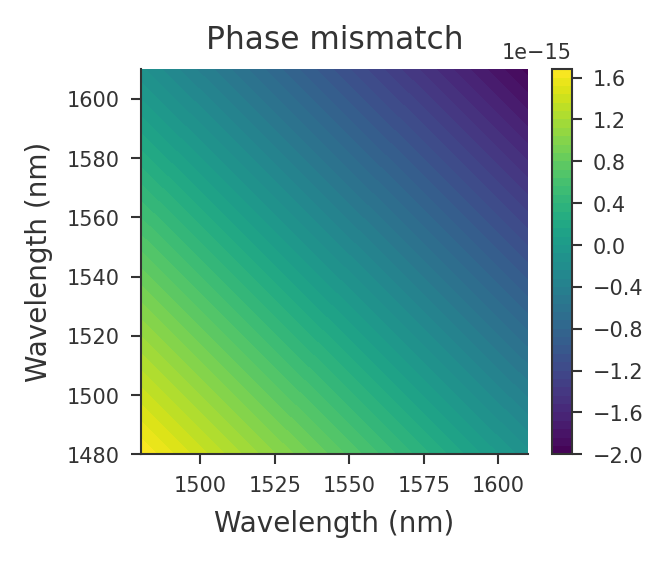

In [21]:
# num_lambdas = 400
lambda_index = np.matrix.flatten(np.argwhere(svd_cwdm > 1e-4))
svd_cwdm = svd_cwdm[lambda_index]  # [:len(lambda_index)]
x_tick_labels = [r"$\lambda_{{{:d}}}$".format(i + 1) for i in range(len(svd_cwdm))]
# print(x_tick_labels)


#################
## PLOTTING ###
#################


### PLOT PHASE MISMATCH ###
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))
cp = ax.contourf(
    X,
    Y,
    phase_mismatch(2 * np.pi * c / X, 2 * np.pi * c / Y, 2 * np.pi * c / 1540),
    levels=50,
)
fig.colorbar(cp)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Wavelength (nm)")
ax.set_title("Phase mismatch")

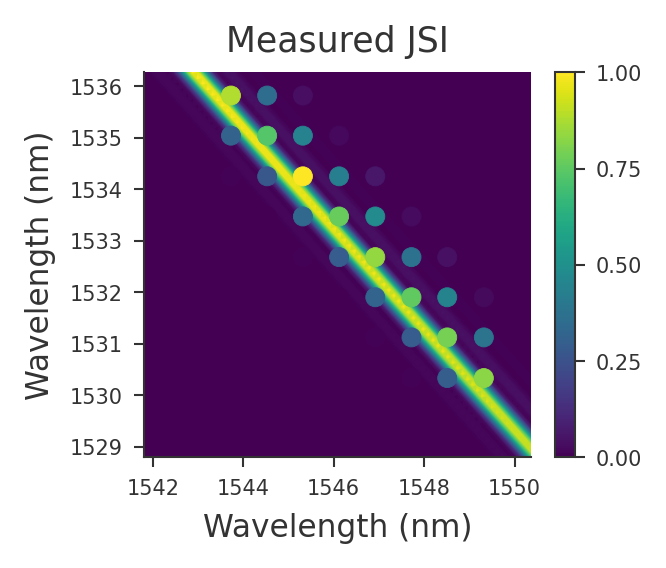

In [22]:
#### PLOT JSIs###

fontsize = 10
fontsize_x = 9
fontsize_y = 9
labelsize = 8
# Plotting modes

levels = np.arange(0, 1.005, 0.005)
ticks = np.arange(0, 1.25, 0.25)
fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

start_id = 570
end_id = 650
start_sig = 450
end_sig = 520

cp = ax.contourf(
    id_wavelengths[start_id:end_id], sig_wavelengths[start_sig:end_sig], JSI_mat[start_sig:end_sig,start_id:end_id] / np.max(JSI_mat[start_sig:end_sig,start_id:end_id] ), 80, levels=levels
)
sc = ax.scatter(
    flat_wl_A,
    flat_wl_B,
    facecolors="None",
    c=flat_coinc / np.max(flat_coinc),
    cmap="viridis",
    s=30,
    alpha=1,
)
ax.set_title("Measured JSI", fontsize=fontsize)
ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
cbar = fig.colorbar(cp, ax=ax)  # , levels = levels)
cbar.set_ticks(ticks)
# plt.clim(0,1)

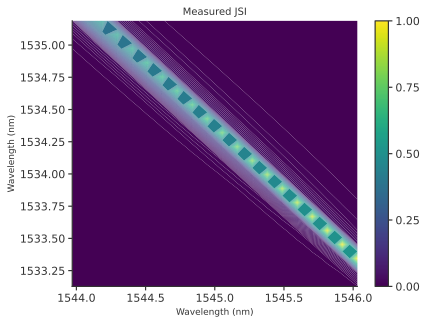

In [91]:
#### PLOT JSIs###

fontsize = 10
fontsize_x = 9
fontsize_y = 9
labelsize = 8
# Plotting modes

levels = np.arange(0, 1.005, 0.005)
ticks = np.arange(0, 1.25, 0.25)
fig, ax = plt.subplots(1, 1)

start_id = 590
end_id = 610
start_sig = 490
end_sig = 510

cp = ax.contourf(
    id_wavelengths[start_id:end_id], sig_wavelengths[start_sig:end_sig], JSI_mat[start_sig:end_sig,start_id:end_id] / np.max(JSI_mat[start_sig:end_sig,start_id:end_id] ), 80, levels=levels
)
# sc = ax.scatter(
#     flat_wl_A,
#     flat_wl_B,
#     facecolors="None",
#     c=flat_coinc / np.max(flat_coinc),
#     cmap="viridis",
#     s=30,
#     alpha=1,
# )
ax.set_title("Measured JSI", fontsize=fontsize)
ax.set_xlabel("Wavelength (nm)", fontsize=fontsize_x)
ax.set_ylabel("Wavelength (nm)", fontsize=fontsize_y)
cbar = fig.colorbar(cp, ax=ax)  # , levels = levels)
cbar.set_ticks(ticks)
# plt.clim(0,1)

Text(-0.01, 1.11, 'a)')

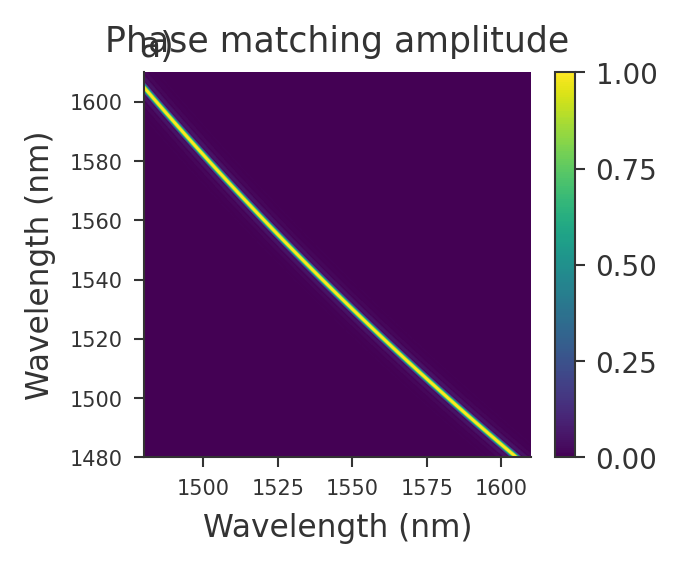